### Машинное обучение
## Домашнее задание №3 - Градиентный бустинг

**Общая информация**

**Срок сдачи:** 14 мая 2024, 23:59   
**Штраф за опоздание:** -2 балла за каждые сутки

Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте.

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге.

Ваше решение тут

y_hat = a(x) - предсказания предыдущих моделей

In [1]:
import numpy as np

In [2]:
def calculate_grad(y, y_hat, loss):
    if loss == 'mse':
        return y - y_hat
    elif loss == 'exp':
        return y * np.exp(-y * y_hat)
    elif loss == 'logit':
        return y / (1 + np.exp(y * y_hat))

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn.


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [3]:
from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

random_state = 42
np.random.seed(random_state)

In [4]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        subsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.base_model_params = kwargs
        self.models = []
        self.init_model = None

    def _calculate_grad(self, y, y_hat):
        if self.loss == 'mse':
            return y - y_hat
        elif self.loss == 'exponential':
            return y * np.exp(-y * y_hat)
        elif self.loss == 'log_loss':
            return y / (1 + np.exp(y * y_hat))

    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if self.loss == 'log_loss' or self.loss == 'exponential':
            y = np.where(y == 0, -1, 1)

        if init_model is None:
            y_pred = np.zeros(X.shape[0])
        else:
            self.init_model = init_model
            self.init_model.fit(X, y)
            y_pred = self.init_model.predict(X)

        for i in range(self.n_estimators):
            grad = self._calculate_grad(y, y_pred)
            model = base_model(**self.base_model_params)

            subsamples = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]), replace=False)
            colsamples = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]), replace=False)
            X_sub = X[subsamples][:, colsamples]
            y_sub = grad[subsamples]

            model.fit(X_sub, y_sub)

            y_pred += self.learning_rate * model.predict(X[:, colsamples])

            self.models.append((model, colsamples))

    def predict(self, X):
        # Ваш код здесь
        if self.init_model is None:
            y_res = np.zeros(X.shape[0])
        else:
            y_res = self.init_model.predict(X)

        for model, colsamples in self.models:
            y_res += self.learning_rate * model.predict(X[:, colsamples])

        if self.loss == 'mse':
            return np.round(y_res).astype(int)
        elif self.loss == 'exponential':
            return np.where(y_res > 0, 1, 0)
        elif self.loss == 'log_loss':
            return (1 / (1 + np.exp(-y_res)) > 0.5).astype(int)

In [5]:
my_clf = MyGradientBoostingClassifier(loss='mse', max_depth=3)
clf = GradientBoostingClassifier()

In [6]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=42)

In [7]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации.


In [8]:
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

X, y = fetch_california_housing(return_X_y=True)

In [9]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [11]:
import time
from tqdm import tqdm

my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.2, n_estimators=100, colsample=0.8, subsample=0.8, max_depth=5)
my_clf.fit(X_train, y_train)

y_res = np.zeros(X_test.shape[0])
test_accuracy = [accuracy_score(y_test, y_res)]
for model, colsamples in tqdm(my_clf.models):
    y_res += my_clf.learning_rate * model.predict(X_test[:, colsamples])
    test_accuracy.append(accuracy_score(y_test, np.where(y_res > 0, 1, 0)))
    time.sleep(1)

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


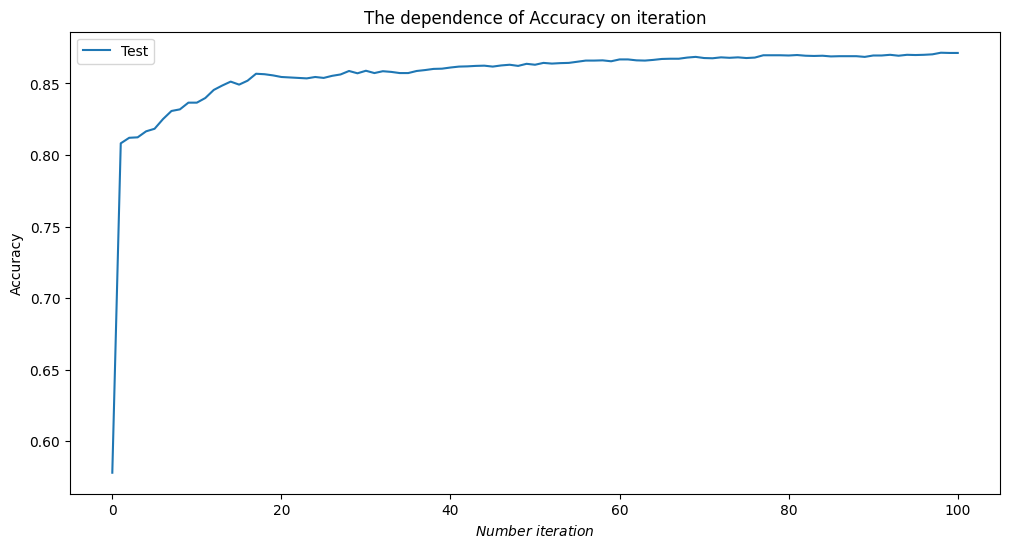

In [12]:
n_iterations_list = range(0, my_clf.n_estimators+1)

plt.figure(figsize=(12, 6))
plt.title("The dependence of Accuracy on iteration")
plt.xlabel(r"$Number$ $iteration$")
plt.ylabel(r"Accuracy")
plt.plot(n_iterations_list, test_accuracy, label='Test')
plt.legend()
plt.show()

In [ ]:
!pip install optuna
import optuna

In [14]:
def objective(trial):

    param = {
        "loss": trial.suggest_categorical("loss", ["mse", "log_loss", "exponential"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.5),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "n_estimators": trial.suggest_int("n_estimators", 1, 100),
        "colsample": trial.suggest_float("colsample", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0)
    }

    gbm = MyGradientBoostingClassifier(random_state=42, **param)

    gbm.fit(X_train, y_train)

    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-13 01:24:29,833] A new study created in memory with name: no-name-32eed8a6-4b23-4947-9e50-891a725f740a
[I 2024-05-13 01:24:32,002] Trial 0 finished with value: 0.7551679586563308 and parameters: {'loss': 'mse', 'learning_rate': 0.044146931497476, 'max_depth': 1, 'n_estimators': 44, 'colsample': 0.931730423212475, 'subsample': 0.9804217343670527}. Best is trial 0 with value: 0.7551679586563308.
[I 2024-05-13 01:24:38,424] Trial 1 finished with value: 0.8869509043927648 and parameters: {'loss': 'mse', 'learning_rate': 0.3794482145141547, 'max_depth': 6, 'n_estimators': 56, 'colsample': 0.864561847986181, 'subsample': 0.9693513836971258}. Best is trial 1 with value: 0.8869509043927648.
[I 2024-05-13 01:24:39,445] Trial 2 finished with value: 0.8468992248062015 and parameters: {'loss': 'mse', 'learning_rate': 0.14167498139915116, 'max_depth': 3, 'n_estimators': 23, 'colsample': 0.8610226582538013, 'subsample': 0.7707698141185122}. Best is trial 1 with value: 0.8869509043927648.


Number of finished trials: 100
Best trial:
  Value: 0.900032299741602
  Params: 
    loss: log_loss
    learning_rate: 0.2550246201220756
    max_depth: 11
    n_estimators: 93
    colsample: 0.6815641840922588
    subsample: 0.629950695949161


__Ответ__: лучший accuracy 0.9 при loss: log_loss, learning_rate: 0.2550246201220756, max_depth: 11, n_estimators: 93, colsample: 0.6815641840922588, subsample: 0.629950695949161

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [ ]:
from sklearn.ensemble import RandomForestRegressor
my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.34419295961063207, colsample=0.7869925539662193, subsample=0.7494709591452795, n_estimators=10, random_state=42)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.8829134366925064


In [ ]:
def bootstrap(X, y, random_state=None):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(X.shape[0], X.shape[0], replace=True)
    return X[idx], y[idx]

def fit_multi_boostings(X_train, y_train, n_models=10, **boosting_params):
    models = []
    for i in range(n_models):
        X_boot, y_boot = bootstrap(X_train, y_train, random_state=i)
        gb_clf = MyGradientBoostingClassifier(**boosting_params)
        gb_clf.fit(X_boot, y_boot)
        models.append(gb_clf)
    return models

def avg_preds(models, X):
    preds = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        preds[:, i] = model.predict(X)
    return np.round(np.mean(preds, axis=1)).astype(int)

models = fit_multi_boostings(X_train, y_train, n_models=10, loss='log_loss', n_estimators=100, learning_rate=0.34419295961063207, max_depth=11)

print(accuracy_score(y_test, avg_preds(models, X_test)))


0.8793604651162791


__Ответ__: Качество улучшить не удалось. Одной из причин является сложность подбора гиперпараметров: в первом случае необходимо подобрать гиперпараметры для бустинга и для RandomForest. Во втором случае необходимо подобрать гиперпараметры для бустинга и количество N бутстрапированных моделей.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [ ]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso


my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.34419295961063207, colsample=0.7869925539662193, subsample=0.7494709591452795)
my_clf.fit(X_train, y_train, init_model=Ridge(alpha=1.0))
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.8998708010335917


In [ ]:
my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.34419295961063207, colsample=0.7869925539662193, subsample=0.7494709591452795, max_depth=5, random_state=42)
my_clf.fit(X_train, y_train, init_model=Ridge(alpha=1.0, random_state=42))
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.8824289405684754


In [ ]:
my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.34419295961063207, colsample=0.7869925539662193, subsample=0.7494709591452795, max_depth=11, random_state=42)
my_clf.fit(X_train, y_train, init_model=Lasso(alpha=0.03, random_state=42))
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.898094315245478


In [ ]:
my_clf = MyGradientBoostingClassifier(loss='log_loss', learning_rate=0.34419295961063207, colsample=0.7869925539662193, subsample=0.7494709591452795, max_depth=11, random_state=42)
my_clf.fit(X_train, y_train, init_model=RandomForestRegressor(random_state=42))
print(accuracy_score(y_test, my_clf.predict(X_test)))

0.8930878552971576


__Ответ__: в целом, получилось улучшить качество благодаря начальной инициализации предсказаний с помощью моделей, а не константным заполнением.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

